<a href="https://colab.research.google.com/github/YichengShen/cis5220-project/blob/main/cis5220_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text-to-SQL

Team: Query Marksman

## Section 0: Config

Flags for choosing which model to run

In [34]:
RUN_NON_DL_MODEL = True
RUN_RNN_MODEL = True

Seed

In [2]:
SEED = 0

## Section 1: Setup

### Install & imports

In [3]:
!pip install nltk
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 86.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 108.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 27.7 MB/s eta 0:00:00


In [4]:
import shutil
import subprocess

import re
import io
import json
import numpy as np
import os
import nltk
from typing import List, Dict, Tuple, Any, Union
from tqdm import tqdm
import torch

In [5]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Mount Drive

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Use GPU if available

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Load data into Colab notebook

Before you run the code below, make sure you download the Spider dataset from [here](https://yale-lily.github.io/spider). Then, you upload the zip file of the dataset to your Drive.

Copy data from Drive into the current runtime

In [8]:
# Create data folder if not exist
!mkdir -p data

# Change this path to where you store spider.zip in your Drive
dataset_zip_path_in_drive = "/content/drive/Shareddrives/CIS 522/spider.zip"
dataset_zip_path_in_runtime = "/content/data/spider.zip"

shutil.copy(dataset_zip_path_in_drive, dataset_zip_path_in_runtime)

'/content/data/spider.zip'

Unzip

In [9]:
!unzip -q -o /content/data/spider.zip -d /content/data/

### Load Python scripts

In [10]:
scripts_path_in_drive = "/content/drive/Shareddrives/CIS 522/scripts"
scripts_path_in_runtime = "/content/scripts"

# Overrides previous scripts folder
if os.path.exists(scripts_path_in_runtime):
    shutil.rmtree(scripts_path_in_runtime)
shutil.copytree(scripts_path_in_drive, scripts_path_in_runtime)

'/content/scripts'

## Section 2: Data Preparation & Cleaning (Milestone 1)

### Helper Functions

In [11]:
def process(sql_data: List[Dict], 
            table_data: List[Dict]) -> Tuple[List[Dict], Dict[str, Dict]]:
    output_tab = {}
    for i in range(len(table_data)):
      table = table_data[i]
      temp = {}
      temp['col_map'] = table['column_names']

      db_name = table['db_id']
      output_tab[db_name] = temp


    output_sql = []
    for i in range(len(sql_data)):
      sql = sql_data[i]
      temp = {}

      # add query metadata
      temp['question'] = sql['question']
      temp['question_tok'] = sql['question_toks']
      temp['query'] = sql['query'].replace('\t', '') # Remove \t, this affects generating the label file
      temp['query_tok'] = sql['query_toks']
      temp['table_id'] = sql['db_id']
      sql_temp = {}

      # process agg/sel
      sql_temp['agg'] = []
      sql_temp['sel'] = []
      gt_sel = sql['sql']['select'][1]
      for tup in gt_sel:
        sql_temp['agg'].append(tup[0])
        sql_temp['sel'].append(tup[1][1][1])
      
      # process where conditions and conjuctions
      sql_temp['cond'] = []
      gt_cond = sql['sql']['where']
      if len(gt_cond) > 0:
        conds = [gt_cond[x] for x in range(len(gt_cond)) if x % 2 == 0]
        for cond in conds:
          curr_cond = []
          curr_cond.append(cond[2][1][1])
          curr_cond.append(cond[1])
          if cond[4] is not None:
            curr_cond.append([cond[3], cond[4]])
          else:
            curr_cond.append(cond[3])
          sql_temp['cond'].append(curr_cond)

      sql_temp['conj'] = [gt_cond[x] for x in range(len(gt_cond)) if x % 2 == 1]

      # process group by / having
      sql_temp['group'] = [x[1] for x in sql['sql']['groupBy']]
      having_cond = []
      if len(sql['sql']['having']) > 0:
        gt_having = sql['sql']['having'][0] # currently only do first having condition
        having_cond.append(gt_having[2][1][0]) # aggregator
        having_cond.append(gt_having[2][1][1]) # column
        having_cond.append(gt_having[1]) # operator
        if gt_having[4] is not None:
          having_cond.append([gt_having[3], gt_having[4]])
        else:
          having_cond.append(gt_having[3])
      sql_temp['group'].append(having_cond)

      # process order by / limit
      order_aggs = []
      order_cols = []
      order_par = -1
      gt_order = sql['sql']['orderBy']
      if len(gt_order) > 0:
        order_aggs = [x[1][0] for x in gt_order[1]]
        order_cols = [x[1][1] for x in gt_order[1]]
        order_par = 1 if gt_order[0] == 'asc' else 0
      sql_temp['order'] = [order_aggs, order_cols, order_par]

      # process intersect/except/union
      sql_temp['special'] = 0
      if sql['sql']['intersect'] is not None:
        sql_temp['special'] = 1
      elif sql['sql']['except'] is not None:
        sql_temp['special'] = 2
      elif sql['sql']['union'] is not None:
        sql_temp['special'] = 3

      temp['sql'] = sql_temp
      output_sql.append(temp)
    return output_sql, output_tab

In [12]:
def load_data_new(sql_paths: Union[str, List[str]], 
                  table_paths: Union[str, List[str]], 
                  use_small: bool = False) -> Tuple[List[Dict], Dict[str, Dict]]:
    if not isinstance(sql_paths, list):
        sql_paths = (sql_paths, )
    if not isinstance(table_paths, list):
        table_paths = (table_paths, )
    sql_data = []
    table_data = {}
    for i, SQL_PATH in enumerate(sql_paths):
        if use_small and i >= 2:
            break
        print(f"Loading data from {SQL_PATH}")
        with open(SQL_PATH) as inf:
            data = json.load(inf)
            sql_data += data
                
    for i, TABLE_PATH in enumerate(table_paths):
        if use_small and i >= 2:
            break
        print(f"Loading data from {TABLE_PATH}")
        with open(TABLE_PATH) as inf:
            table_data= json.load(inf)
    # print sql_data[0]
    sql_data, table_data = process(sql_data, table_data)
    return sql_data, table_data

### Load Clean Data

In [13]:
sql_data_train, table_data = load_data_new(["/content/data/spider/train_spider.json"], ["/content/data/spider/tables.json"], use_small=False)

Loading data from /content/data/spider/train_spider.json
Loading data from /content/data/spider/tables.json


In [14]:
sql_data_others_train, table_data = load_data_new(["/content/data/spider/train_others.json"], ["/content/data/spider/tables.json"], use_small=False)

Loading data from /content/data/spider/train_others.json
Loading data from /content/data/spider/tables.json


In [15]:
sql_data_dev, table_data = load_data_new(["/content/data/spider/dev.json"], ["/content/data/spider/tables.json"], use_small=False)

Loading data from /content/data/spider/dev.json
Loading data from /content/data/spider/tables.json


## Section 3: EDA

### SQL Data

Spider database contains 200 databases, with multiple tables, 10,181 questions, and 5,693 corresponding complex SQL queries. There's no overlapps in train and test.

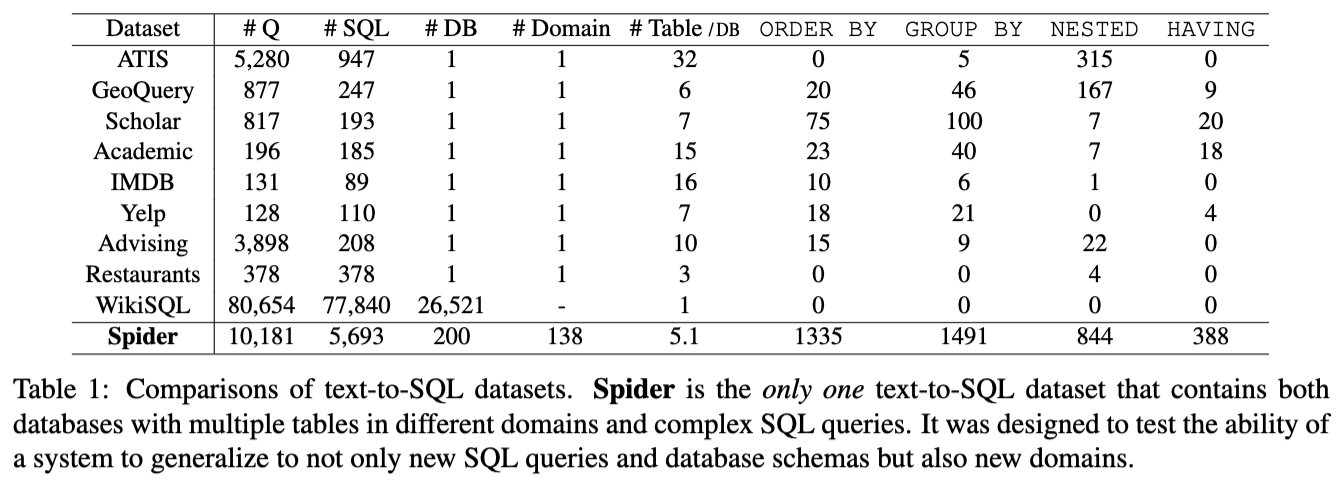

In [16]:
print(f"Number of training data: {len(sql_data_train)}")
print(f"Number of extra training data: {len(sql_data_others_train)}")
print(f"Number of eval data: {len(sql_data_dev)}")

Number of training data: 7000
Number of extra training data: 1659
Number of eval data: 1034


One example looks like:

In [17]:
sql_data_train[0]

{'question': 'How many heads of the departments are older than 56 ?',
 'question_tok': ['How',
  'many',
  'heads',
  'of',
  'the',
  'departments',
  'are',
  'older',
  'than',
  '56',
  '?'],
 'query': 'SELECT count(*) FROM head WHERE age  >  56',
 'query_tok': ['SELECT',
  'count',
  '(',
  '*',
  ')',
  'FROM',
  'head',
  'WHERE',
  'age',
  '>',
  '56'],
 'table_id': 'department_management',
 'sql': {'agg': [3],
  'sel': [0],
  'cond': [[10, 3, 56.0]],
  'conj': [],
  'group': [[]],
  'order': [[], [], -1],
  'special': 0}}

For data containde in spider_others, more "multiple text questions to same complex sql query pairings" are provided. 

---
We can see the examples below:

In [18]:
sql_data_others_train[0]

{'question': 'what is the biggest city in wyoming',
 'question_tok': ['what', 'is', 'the', 'biggest', 'city', 'in', 'wyoming'],
 'query': 'SELECT city_name FROM city WHERE population  =  ( SELECT MAX ( population ) FROM city WHERE state_name  =  "wyoming" ) AND state_name  =  "wyoming";',
 'query_tok': ['SELECT',
  'city_name',
  'FROM',
  'city',
  'WHERE',
  'population',
  '=',
  '(',
  'SELECT',
  'MAX',
  '(',
  'population',
  ')',
  'FROM',
  'city',
  'WHERE',
  'state_name',
  '=',
  '``',
  'wyoming',
  "''",
  ')',
  'AND',
  'state_name',
  '=',
  '``',
  'wyoming',
  "''",
  ';'],
 'table_id': 'geo',
 'sql': {'agg': [0],
  'sel': [7],
  'cond': [[8,
    2,
    {'from': {'table_units': [['table_unit', 1]], 'conds': []},
     'select': [False, [[1, [0, [0, 8, False], None]]]],
     'where': [[False, 2, [0, [0, 10, False], None], '"wyoming"', None]],
     'groupBy': [],
     'having': [],
     'orderBy': [],
     'limit': None,
     'intersect': None,
     'union': None,
    

In [19]:
sql_data_others_train[1]

{'question': 'what wyoming city has the largest population',
 'question_tok': ['what',
  'wyoming',
  'city',
  'has',
  'the',
  'largest',
  'population'],
 'query': 'SELECT city_name FROM city WHERE population  =  ( SELECT MAX ( population ) FROM city WHERE state_name  =  "wyoming" ) AND state_name  =  "wyoming";',
 'query_tok': ['SELECT',
  'city_name',
  'FROM',
  'city',
  'WHERE',
  'population',
  '=',
  '(',
  'SELECT',
  'MAX',
  '(',
  'population',
  ')',
  'FROM',
  'city',
  'WHERE',
  'state_name',
  '=',
  '``',
  'wyoming',
  "''",
  ')',
  'AND',
  'state_name',
  '=',
  '``',
  'wyoming',
  "''",
  ';'],
 'table_id': 'geo',
 'sql': {'agg': [0],
  'sel': [7],
  'cond': [[8,
    2,
    {'from': {'table_units': [['table_unit', 1]], 'conds': []},
     'select': [False, [[1, [0, [0, 8, False], None]]]],
     'where': [[False, 2, [0, [0, 10, False], None], '"wyoming"', None]],
     'groupBy': [],
     'having': [],
     'orderBy': [],
     'limit': None,
     'intersect': 

### Database Schema Data

In [20]:
len(table_data)

166

In [21]:
table_data['yelp']

{'col_map': [[-1, '*'],
  [0, 'bid'],
  [0, 'business id'],
  [0, 'name'],
  [0, 'full address'],
  [0, 'city'],
  [0, 'latitude'],
  [0, 'longitude'],
  [0, 'review count'],
  [0, 'is open'],
  [0, 'rating'],
  [0, 'state'],
  [1, 'id'],
  [1, 'business id'],
  [1, 'category name'],
  [2, 'uid'],
  [2, 'user id'],
  [2, 'name'],
  [3, 'cid'],
  [3, 'business id'],
  [3, 'count'],
  [3, 'day'],
  [4, 'id'],
  [4, 'business id'],
  [4, 'neighbourhood name'],
  [5, 'rid'],
  [5, 'business id'],
  [5, 'user id'],
  [5, 'rating'],
  [5, 'text'],
  [5, 'year'],
  [5, 'month'],
  [6, 'tip id'],
  [6, 'business id'],
  [6, 'text'],
  [6, 'user id'],
  [6, 'likes'],
  [6, 'year'],
  [6, 'month']]}

In [22]:
table_data['concert_singer']

{'col_map': [[-1, '*'],
  [0, 'stadium id'],
  [0, 'location'],
  [0, 'name'],
  [0, 'capacity'],
  [0, 'highest'],
  [0, 'lowest'],
  [0, 'average'],
  [1, 'singer id'],
  [1, 'name'],
  [1, 'country'],
  [1, 'song name'],
  [1, 'song release year'],
  [1, 'age'],
  [1, 'is male'],
  [2, 'concert id'],
  [2, 'concert name'],
  [2, 'theme'],
  [2, 'stadium id'],
  [2, 'year'],
  [3, 'concert id'],
  [3, 'singer id']]}

## Section 4: Code for Evaluation

In [23]:
def evaluate(preds_file, labels_file, evaluation_type="all", 
             database_dir="./data/spider/database", 
             table_file="./data/spider/tables.json",
             verbose="False"):
    """
    Runs the evaluation script for the Spider dataset using the provided labels and predictions files.
    It prints the evaluation results to the console and returns the subprocess result object.

    Args:
        preds_file (str): Path to the predictions file. In this file, each line is `a ground-truth SQL \t db_id`.
        labels_file (str): Path to the labels (gold) file. In this file, each line is a predicted SQL.
        evaluation_type (str): Evaluation type, can be 'all', 'exec', or 'match'.
        database_dir (str): Path to the directory containing the Spider dataset's database files.
        table_file (str): Path to the tables.json file from the Spider dataset.
        verbose (str): Flag to trun on or off printing details.

    Returns:
        result (subprocess.CompletedProcess): A CompletedProcess instance representing the evaluation subprocess.
                                              It contains attributes like 'stdout' and 'stderr' to access the output
                                              and error messages respectively.
    """

    cmd = [
        "python3", "scripts/evaluation.py",
        "--gold", labels_file,
        "--pred", preds_file,
        "--etype", evaluation_type,
        "--db", database_dir,
        "--table", table_file,
        "--verbose", verbose
    ]

    result = subprocess.run(cmd, capture_output=True, text=True)

    print(result.stdout)

    return result

## Section 5: Non-DL Model (Milestone 2)

In [35]:
import json
import numpy as np
import torch
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

### Random Forest Model

In [36]:
class RF_TextToSQL(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.vectorizer = HashingVectorizer(n_features=2**16)
        self.model = RandomForestClassifier(n_estimators=60)
        self.label_encoder = LabelEncoder()

    def fit(self, X, y):
        y_encoded = self.label_encoder.fit_transform(y)
        X_vec = self.vectorizer.transform(X)
        self.model.fit(X_vec, y_encoded)

    def predict(self, X):
        X_vec = self.vectorizer.transform(X)
        y_pred_encoded = self.model.predict(X_vec)
        return self.label_encoder.inverse_transform(y_pred_encoded)

    def write_predictions_to_file(self, text_questions, labels, preds_filename, labels_filename):
        predicted_sql_queries = self.predict(text_questions)

        with open(preds_filename, 'w') as output_file:
            for pred in predicted_sql_queries:
                output_file.write(pred + '\n')

        with open(labels_filename, 'w') as output_file:
            for label in labels:
                output_file.write(label + '\n')
                

def sql_dict_to_string(sql_dict):
    sql_string = json.dumps(sql_dict, separators=(',', ':'))
    return sql_string

def get_text_and_sql(data, table_data, add_column_names=False):
    text = []
    sql = []
    sql_with_table_id = []

    for item in data:
        table_id = item['table_id']

        if add_column_names:
            # Get column names in a table and concat them into a string
            column_names = [col[1] for col in table_data[table_id]['col_map']]
            column_names_str = '; '.join(column_names)
            text.append(f"{item['question']} | {table_id} | {column_names_str}")
        else: 
            text.append(item['question'])
        sql.append(item['query'])
        sql_with_table_id.append(f"{item['query']}\t{table_id}")
        # sql.append(sql_dict_to_string(item['sql']))

    return text, sql, sql_with_table_id

In [37]:
if RUN_NON_DL_MODEL:
    # Preprocess data
    train_text, train_sql, train_sql_with_table_id = get_text_and_sql(sql_data_train, table_data)
    dev_text, dev_sql, dev_sql_with_table_id = get_text_and_sql(sql_data_dev, table_data)

    # Use a smaller subset of the dataset
    SUBSET_SIZE = 0.99
    _, _, train_sql_with_table_id, _ = train_test_split(train_text, train_sql_with_table_id, train_size=SUBSET_SIZE, random_state=SEED)
    train_text, _, train_sql, _ = train_test_split(train_text, train_sql, train_size=SUBSET_SIZE, random_state=SEED)

    # Train-test split
    TEST_SIZE = 0.3
    _, _, y_train_with_table_id, y_val_with_table_id = train_test_split(train_text, train_sql_with_table_id, test_size=TEST_SIZE, random_state=SEED)
    X_train, X_val, y_train, y_val = train_test_split(train_text, train_sql, test_size=TEST_SIZE, random_state=SEED)

    # Initialize model
    model = RF_TextToSQL()

    # Train model
    model.fit(X_train, y_train)

### Evaluation - Non-DL model

Evaluation on the training set

In [38]:
if RUN_NON_DL_MODEL:
    # Write predictions of training set to a file
    model.write_predictions_to_file(X_train, y_train_with_table_id, 'preds.txt', 'labels.txt')

    evaluation_train = evaluate(preds_file="preds.txt", 
                                labels_file="labels.txt", 
                                evaluation_type="all", 
                                database_dir="./data/spider/database", 
                                table_file="./data/spider/tables.json",
                                verbose="False")

                     easy                 medium               hard                 extra                all                 
count                1159                 1943                 1001                 748                  4851                
=====================   EXECUTION ACCURACY     =====================
execution            0.997                0.999                1.000                0.999                0.999               

====================== EXACT MATCHING ACCURACY =====================
exact match          0.997                0.999                1.000                1.000                0.999               

---------------------PARTIAL MATCHING ACCURACY----------------------
select               1.000                1.000                1.000                1.000                1.000               
select(no AGG)       1.000                1.000                1.000                1.000                1.000               
where                1.000         

Evaluation on the test set

In [39]:
if RUN_NON_DL_MODEL:
    model.write_predictions_to_file(dev_text, dev_sql_with_table_id, 'preds.txt', 'labels.txt')

    evaluation_test = evaluate(preds_file="preds.txt", 
                              labels_file="labels.txt", 
                              evaluation_type="all", 
                              database_dir="./data/spider/database", 
                              table_file="./data/spider/tables.json",
                              verbose="False")

                     easy                 medium               hard                 extra                all                 
count                248                  446                  174                  166                  1034                
=====================   EXECUTION ACCURACY     =====================
execution            0.016                0.000                0.006                0.000                0.005               

====================== EXACT MATCHING ACCURACY =====================
exact match          0.020                0.000                0.000                0.000                0.005               

---------------------PARTIAL MATCHING ACCURACY----------------------
select               0.778                0.000                0.500                0.000                0.360               
select(no AGG)       0.778                0.000                0.500                0.000                0.360               
where                0.333         

# Section 6: Base DL Model

### RNN Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from transformers import BertTokenizer

from torch.cuda.amp import GradScaler, autocast

Create custom dataset and dataloader

In [ ]:
class TextToSQLDataset(Dataset):
    def __init__(self, data, schema, text_tokenizer, sql_tokenizer, max_seq_length):
        self.data = data
        self.schema = schema
        self.text_tokenizer = text_tokenizer
        self.sql_tokenizer = sql_tokenizer
        self.max_seq_length = max_seq_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        question = item['question']
        query = item['query']
        
        # Tokenize the feature (text question)
        tokens = self.text_tokenizer.encode_plus(
            question,
            add_special_tokens=False,
            max_length=self.max_seq_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        input_ids = tokens['input_ids'][0]
        attention_mask = tokens['attention_mask'][0]

        # Tokenize the label (sql query)
        label_tokenized = self.sql_tokenizer.encode(
            query,
            add_special_tokens=False,
            max_length=self.max_seq_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'label': label_tokenized
        }

In [ ]:
if RUN_RNN_MODEL:
    pretrained_model_name = 'bert-base-uncased'
    text_tokenizer = BertTokenizer.from_pretrained(pretrained_model_name)
    sql_tokenizer = BertTokenizer.from_pretrained(pretrained_model_name)

    # Define a custom SQL vocabulary
    sql_keywords = [
        "SELECT", "FROM", "WHERE", "AND", "OR", "NOT", "INSERT", "INTO", "VALUES",
        "UPDATE", "SET", "DELETE", "CREATE", "TABLE", "ALTER", "DROP", "INDEX",
        "UNION", "JOIN", "LEFT", "RIGHT", "INNER", "OUTER", "ON", "AS", "DISTINCT",
        "GROUP", "BY", "HAVING", "ORDER", "ASC", "DESC", "LIMIT", "OFFSET", "BETWEEN",
        "NULL", "LIKE", "IN", "EXISTS", "ALL", "ANY", "SOME", "CASE", "WHEN", "THEN",
        "ELSE", "END", "CAST", "IS", "COUNT", "SUM", "AVG", "MIN", "MAX"
    ]

    # Add the SQL keywords to the tokenizer's vocabulary
    for keyword in sql_keywords:
        sql_tokenizer.add_tokens([keyword], special_tokens=True)

    # Set the maximum sequence length for the input
    max_seq_length = 64

    # Load data and schema
    data = sql_data_train
    schema = table_data

    # Create an instance of the custom dataset class
    text_to_sql_dataset = TextToSQLDataset(data, schema, text_tokenizer, sql_tokenizer, max_seq_length)

    # Create a DataLoader for training
    batch_size = 32
    train_loader = DataLoader(text_to_sql_dataset, batch_size=batch_size, shuffle=True)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
class RNN_TextToSQL(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super(RNN_TextToSQL, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, input_ids, attention_mask):
        # Embed the tokens
        embedded = self.embedding(input_ids)
        
        # Apply the attention mask
        embedded = embedded * attention_mask.unsqueeze(-1)
        
        # Pass the embedded tokens through the RNN
        rnn_output, _ = self.rnn(embedded)
        
        # Pass the entire sequence through the fully connected layer
        out = self.fc(rnn_output)
        
        return out

def predict(model, text, text_tokenizer, sql_tokenizer, device):
    model.eval()

    # Tokenize the input text
    tokens = text_tokenizer.encode_plus(
        text,
        add_special_tokens=False,
        max_length=max_seq_length,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

    input_ids = tokens['input_ids']
    attention_mask = tokens['attention_mask']

    # Move input tensors to the device
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)

    # Disable gradient calculation during prediction
    with torch.no_grad():
        # Pass the input tensors through the model
        logits = model(input_ids, attention_mask)

    # Get the predicted token indices
    predicted_indices = torch.argmax(logits, dim=-1)

    # Convert the predicted token indices to text
    predicted_text = sql_tokenizer.decode(predicted_indices[0].tolist(), skip_special_tokens=True)

    return predicted_text

In [ ]:
if RUN_RNN_MODEL:
    vocab_size = len(text_tokenizer.vocab)
    embedding_dim = 256
    hidden_dim = 512
    output_dim = len(sql_tokenizer.vocab) 
    dropout = 0.3
    n_layers = 8

    n_epochs = 50

    model = RNN_TextToSQL(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout)
    model = model.to(device)

    # Define the loss function and optimizer
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-5)

    # Create a GradScaler instance for mixed-precision training
    scaler = GradScaler()

    # Training loop
    for epoch in range(n_epochs):
        # Wrap the DataLoader with tqdm for progress bar
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{n_epochs}")

        for step, batch in enumerate(progress_bar):
            # Unpack the data and move it to the device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass with autocast for mixed-precision training
            with autocast():
                outputs = model(input_ids, attention_mask)

                # Calculate the loss
                loss = loss_function(outputs.view(-1, outputs.shape[-1]), labels.view(-1))

            # Scale the loss and perform a backward pass
            scaler.scale(loss).backward()

            # Update the weights
            scaler.step(optimizer)
            scaler.update()

            # Update the progress bar description with the current loss
            progress_bar.set_description(f"Epoch {epoch + 1}/{n_epochs}, Loss: {loss.item():.4f}")

Epoch 19/50, Loss: 3.0954:  72%|███████▏  | 158/219 [00:18<00:05, 10.24it/s]

In [ ]:
if RUN_RNN_MODEL:
    input_text = sql_data_dev[0]['question']
    predicted_query = predict(model, input_text, text_tokenizer, sql_tokenizer, device)
    print(predicted_query)

select t ( from from from from from from


This prediction shows that this model has not captured the structure of SQL queries. This shows the difficulty and complexity of our task. We need to increase the model capacity a lot and train it more. So, we moved on from this model and spent our time on the more advanced models.

# Advanced Models

Advanced models are in other notebooks.